# The impact of ENSO and AO with Arctic Albedo Anomalies

#### Imports

In [75]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy 
from cartopy.util import add_cyclic_point
import cartopy.mpl.ticker as cticker
import xesmf as xe
import matplotlib.colors as colors
from scipy.stats import pearsonr
from scipy.stats import ttest_ind

#### Helper Functions

In [7]:
def plot_large_polar_common_ax():
    fig = plt.figure(figsize=(20,20))
    ax=plt.axes(projection=ccrs.NorthPolarStereo())
    ax.set_extent([-180, 180, 30, 90], ccrs.PlateCarree())

    # add reference lines
    ax.coastlines()
    ax.gridlines()
    
    return ax


---

## Data Overview

__Datasets used in this project:__

* Arctic Oscillation index
* Nino34 index
* ASRv2 Albedo fraction climatology
* ASRv2 Albedo fraction anomalies (2000-2016)


_All datasets contain monthly mean values. Index and anomaly datasets are in the time range 2000-01-01 to 2016-12-01. The mesh gridded Arctic System Reanalysis datasets have been regridded in a separate notebook (RegridAll.ipynb) to $0.1^{\circ}$ lat/lon grid and subset to $0-90^{\circ}$ N latitutes. The index datasets have been converted to NetCDF files with a single time dimension and subset to the same time range using the LoadAOandNino.ipynb notebook. Climatologies and anomalies were initialy calculated (on the original irregular ASR grid) using the CalculateClimAndAnoms.ipynb notebook._


In [12]:
clim_path='/home/ubuntu/asr15km.anl.2D.latlon.clim.ALBEDO.nc'
anoms_path='/home/ubuntu/asr15km.anl.2D.latlon.anoms.ALBEDO.nc'
ao_path='/home/ubuntu/indexes/ao.nc'
nino34_path='/home/ubuntu/indexes/nino34.nc'

In [13]:
clim=xr.open_dataset(clims_path)
anoms=xr.open_dataset(anoms_path)
ao=xr.open_dataset(ao_path)
nino34=xr.open_dataset(nino34_path)

#### ALBEDO Climatologies Plot

Text(0.5, 0.98, 'ARSv2 Arctic Albedo Fraction Climatology (2000-2016)')

<Figure size 1440x1440 with 0 Axes>

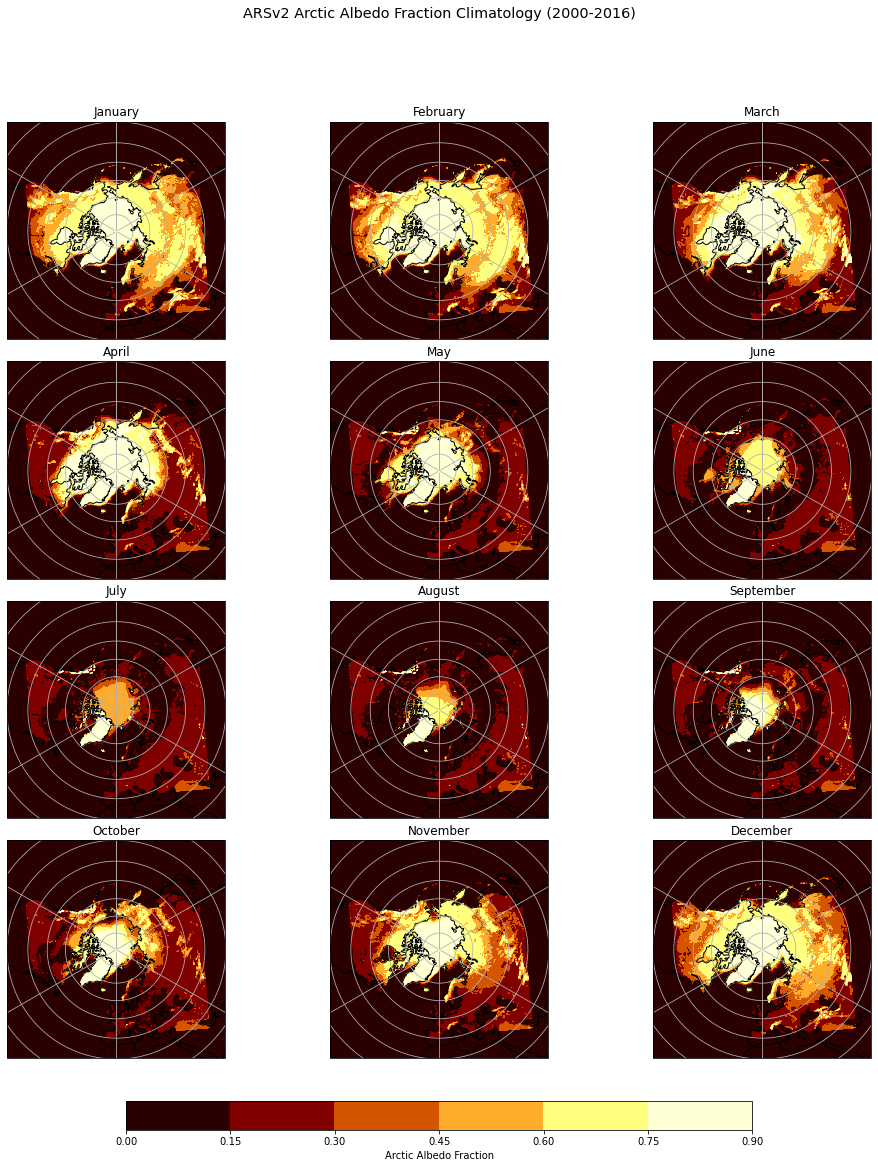

In [23]:
fig = plt.figure(figsize=(20,20))

fig, axs = plt.subplots(nrows=4,ncols=3,
                        subplot_kw={'projection': ccrs.NorthPolarStereo()},
                        figsize=(14.5,20))
axs=axs.flatten()

for i,m in enumerate( ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']):
    ax=axs[i]
    ds=clim['ALBEDO'][i]
    cs=ax.contourf(ds['lon'], ds['lat'], ds, 
            transform=ccrs.PlateCarree(),
            cmap='afmhot')
    
    # add reference lines
    ax.coastlines()
    ax.gridlines()
    
    ax.set_title(m)
    ax.set_extent([-180, 180, 30, 90], ccrs.PlateCarree())

fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.1)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='Arctic Albedo Fraction', pad=0)

# Add a big title at the top
plt.suptitle('ARSv2 Arctic Albedo Fraction Climatology (2000-2016)', size='x-large')


#### Arctic Oscillation Index

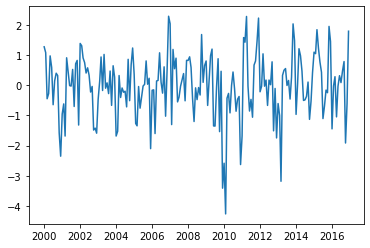

In [25]:
plt.plot(ao['time'],ao['ao'])

#### Nino34 Index

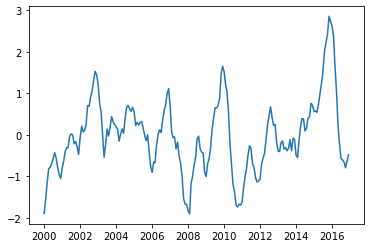

In [27]:
plt.plot(nino34['time'],nino34['sst'])

---

## Data Analysis

### Composite Analysis

__Calculate AO positive and negative composites__

In [36]:
ao_pos=ao['ao'].where(ao['ao'] >= 0).dropna(dim='time')
ao_neg=ao['ao'].where(ao['ao'] < 0).dropna(dim='time')

num_ao_pos=len(ao_pos)
num_ao_neg=len(ao_neg)

mean_anoms_ao_pos=anoms['ALBEDO'].sel(time=ao_pos['time']).mean(dim='time')
mean_anoms_ao_neg=anoms['ALBEDO'].sel(time=ao_neg['time']).mean(dim='time')

#### Positive Arctic Oscillation ALBEDO Composite Map

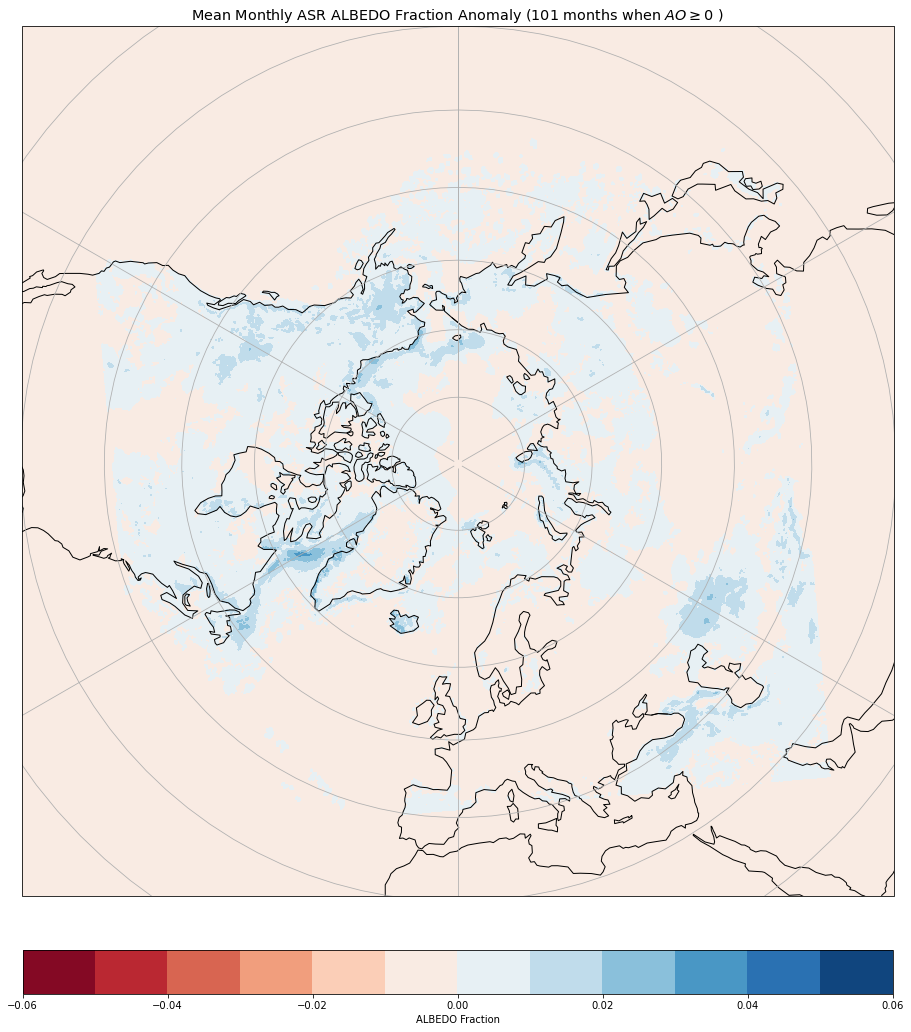

In [58]:
ax = plot_large_polar_common_ax()
dr = mean_anoms_ao_pos
clevs=np.arange(-0.06,0.07,0.01)

cs=ax.contourf(dr['lon'], dr['lat'], dr, clevs,
            transform=ccrs.PlateCarree(),
            cmap='RdBu')

cbar=plt.colorbar(cs,orientation='horizontal',label='ALBEDO Fraction',shrink=0.78,pad=0.05)

plt.title('Mean Monthly ASR ALBEDO Fraction Anomaly (101 months when $AO \geq 0 $ )', size='x-large')
plt.show()

#### Negative Arctic Oscillation ALBEDO Composite Map

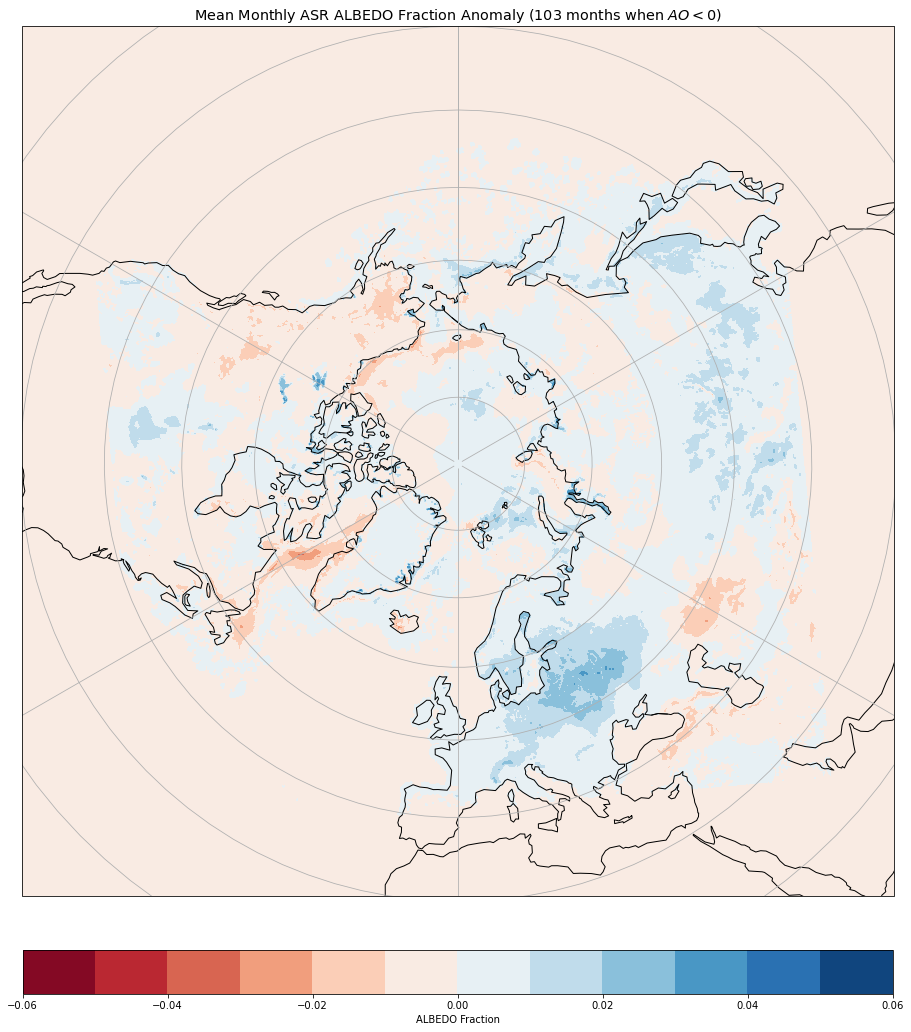

In [53]:
ax = plot_large_polar_common_ax()
dr = mean_anoms_ao_neg
clevs=np.arange(-0.06,0.07,0.01)

cs=ax.contourf(dr['lon'], dr['lat'], dr, clevs,
            transform=ccrs.PlateCarree(),
            cmap='RdBu')

cbar=plt.colorbar(cs,orientation='horizontal',label='ALBEDO Fraction',shrink=0.78,pad=0.05)

plt.title('Mean Monthly ASR ALBEDO Fraction Anomaly (103 months when $AO < 0$)', size='x-large')
plt.show()

**Calculate AO ALBEDO composite difference and t-statistic significance**

_pval<=0.05_ required to demonstrate significance.

In [56]:
mean_anoms_ao_diff=mean_anoms_ao_pos-mean_anoms_ao_neg

anoms_ao_pos=anoms['ALBEDO'].sel(time=ao_pos['time'])
anoms_ao_neg=anoms['ALBEDO'].sel(time=ao_neg['time'])

In [59]:
tstat,pval=ttest_ind(anoms_ao_pos,anoms_ao_neg,equal_var=False)

In [65]:
p=0.05
ao_diff_mask=mean_anoms_ao_diff.where(pval<=p)

#### AO ALBEDO Composite Difference Map with $p \leq 0.05$ Significance Hatchmarked

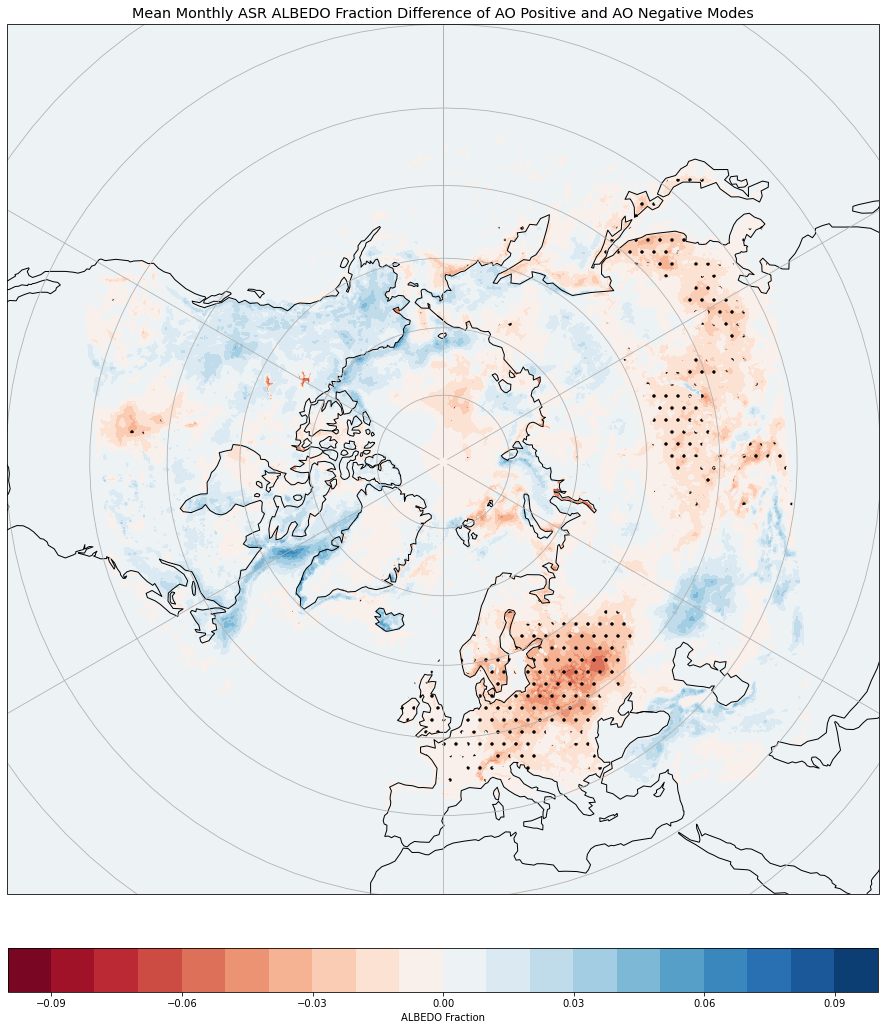

In [71]:
ax = plot_large_polar_common_ax()
dr = mean_anoms_ao_diff
clevs=np.arange(-0.10,0.11,0.01)

# # AO difference 
cs=ax.contourf(dr['lon'], dr['lat'],dr,clevs,
            transform=ccrs.PlateCarree(),
            cmap='RdBu')

# T-statistic significance map
ax.contourf(dr['lon'], dr['lat'],ao_diff_mask,[0,1],
             transform = ccrs.PlateCarree(),colors='None',
             hatches=['.',''],extend='both',alpha=0)


cbar=plt.colorbar(cs,orientation='horizontal',label='ALBEDO Fraction',shrink=0.78,pad=0.05)

plt.title('Mean Monthly ASR ALBEDO Fraction Difference of AO Positive and AO Negative Modes', size='x-large')
plt.show()

#### Composite Result Summary

Composite analysis demonstrates statistically significant differences in the Arctic albedo fraction anomalies between months when the Arctic Oscillation is in negative and positive modes. The difference is most clear and significant in the 50-60N zone. This result is expected because the Arctic Oscillation has a major effect on temperatures at those latitutes. 

### Linear Regression Analysis

**Calculate AO Index and ALBEDO linear regression**

In [76]:
ds=anoms['ALBEDO']

nx=len(ds['lon'])
ny=len(ds['lat'])

p_array=np.zeros((ny,nx))
r_array=np.zeros((ny,nx))

for i in range(nx):
    for j in range(ny):
        r,p=pearsonr(ao['ao'],ds[:,j,i])
        r_array[j,i]=r
        p_array[j,i]=p

r_array.shape

/home/ubuntu/anaconda3/envs/clim680-xesmf/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


(900, 3601)

In [77]:
ao_r_array=r_array
ao_p_array=p_array

In [79]:
p=0.05
ao_r_sigmask=np.where(ao_p_array<p,ao_r_array,np.nan)

#### AO Index and ALBEDO Linear Regression Map

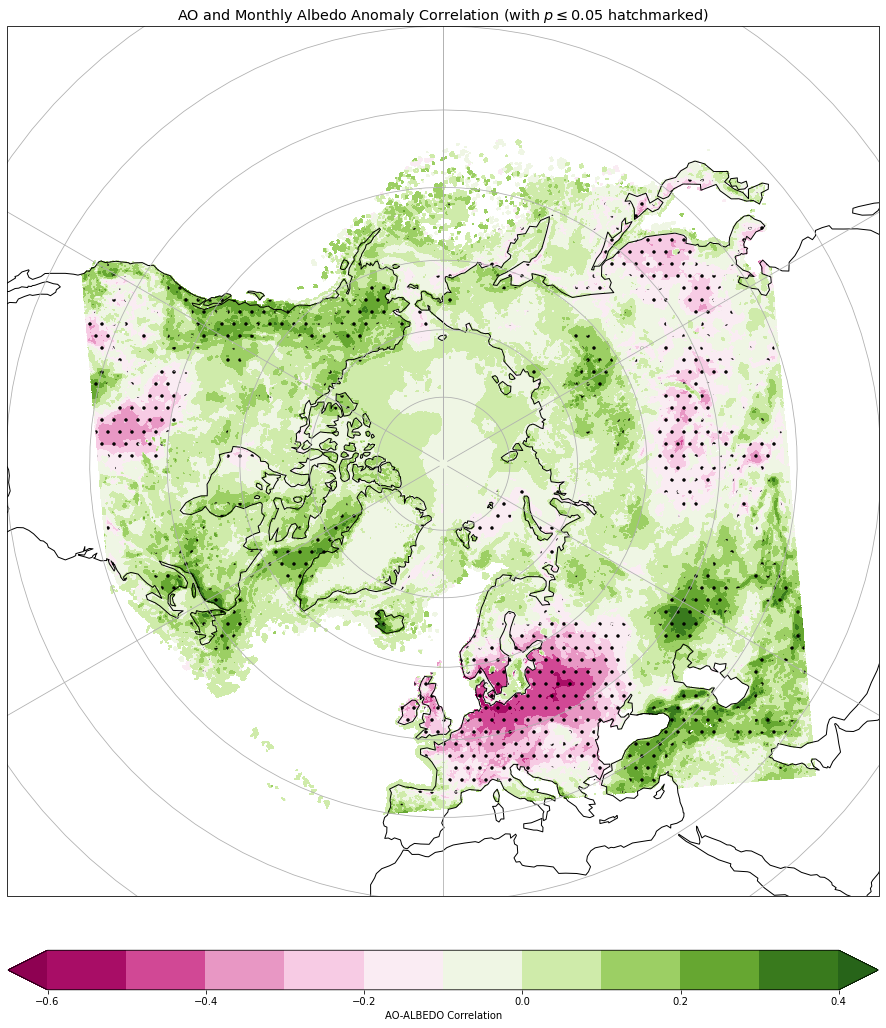

In [84]:
ax = plot_large_polar_common_ax()
clevs=np.arange(-0.6,0.5,0.1)

cs=ax.contourf(anoms['lon'],anoms['lat'],
            ao_r_array,clevs,
            transform=ccrs.PlateCarree(),
            cmap='PiYG',extend='both')

ax.contourf(anoms['lon'],anoms['lat'],ao_r_sigmask,[0,1],
            transform = ccrs.PlateCarree(),colors='None',
            hatches=['.','.'],extend='both',alpha=0)


cbar=plt.colorbar(cs,orientation='horizontal',label='AO-ALBEDO Correlation',shrink=0.78,pad=0.05)

plt.title('AO and Monthly Albedo Anomaly Correlation (with $p \leq 0.05$ hatchmarked)', size='x-large')
plt.show()

**Calculate Nino3.4 Index and ALBEDO simple correlation**

In [82]:
nino34_rmap=xr.corr(nino34['sst'],anoms['ALBEDO'],dim='time')

#### Nino34 and ALBEDO Correlation Map

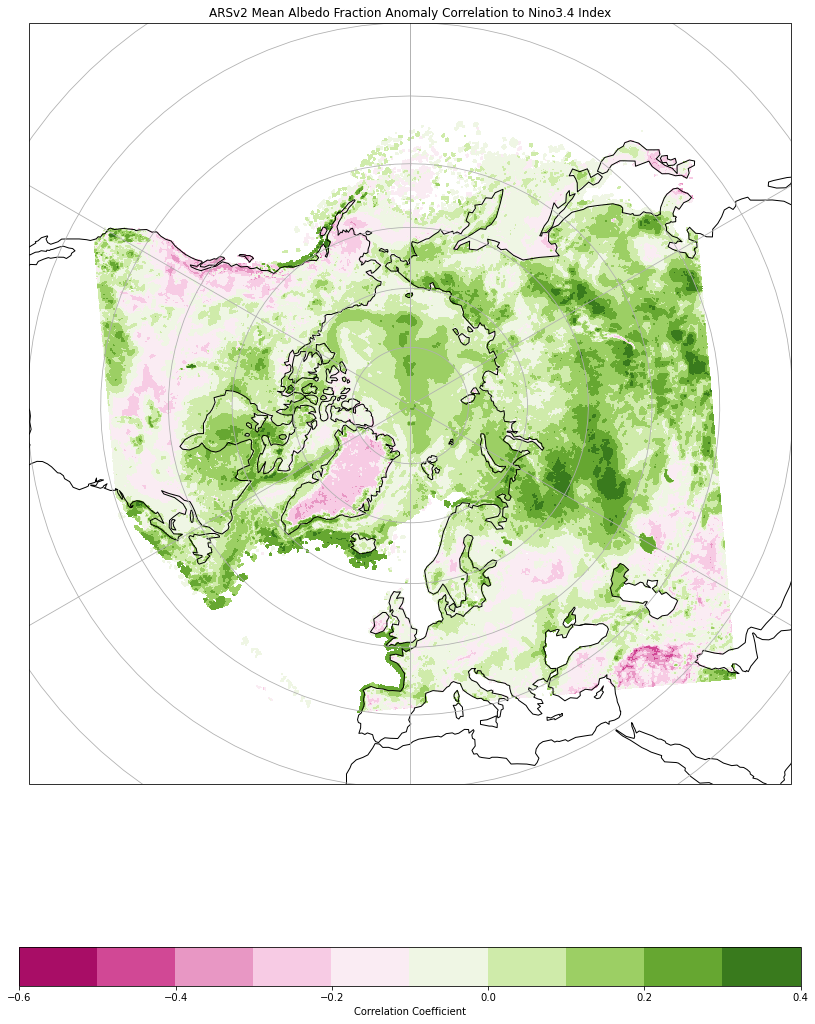

In [88]:
fig = plt.figure(figsize=(20,20))

# specify axis map projection
ax=plt.axes(projection=ccrs.NorthPolarStereo())

clevs=np.arange(-0.6,0.5,0.1)

# make a filled contour plot
cs=ax.contourf(nino34_rmap['lon'], nino34_rmap['lat'], 
            nino34_rmap, clevs,
            transform=ccrs.PlateCarree(),
            cmap='PiYG')

ax.set_extent([-180, 180, 30, 90], ccrs.PlateCarree())


# add reference lines
ax.coastlines()
ax.gridlines()

cbar=plt.colorbar(cs,orientation='horizontal',shrink=0.7,label='Correlation Coefficient')

plt.title('ARSv2 Mean Albedo Fraction Anomaly Correlation to Nino3.4 Index')
plt.show()